In [1]:
import os
import json
import gc
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import plot_model
import fasttext

In [2]:
# https://www.kaggle.com/opanichev/tf2-0-qa-binary-classification-baseline
def build_train(train_path, n_rows=200000):
    with open(train_path) as f:
        processed_rows = []

        for i in tqdm(range(n_rows)):
            line = f.readline()
            if not line:
                break

            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            annotations = line['annotations'][0]
            start_long = annotations['long_answer']['start_token']
            if start_long == -1:
                continue
            end_long = annotations['long_answer']['end_token']
             
            if len(annotations['short_answers'])>0:
                start_short = annotations['short_answers'][0]['start_token']
                end_short = annotations['short_answers'][0]['end_token']
                short = " ".join(text[start_short:end_short])
            else:
                short = "NONE"
            try:
                processed_rows.append({
                        'text': " ".join(text[start_long:end_long]),
                        'question': question,
                        'short_answer':"startseq " + short + " endseq",
                        'annotation_id': annotations['annotation_id']
                })
            except:
                continue

        train = pd.DataFrame(processed_rows)
        
        return train

In [3]:
def build_test(test_path, submission_path):
    test = pd.read_json(test_path, orient='records', lines=True, dtype={'example_id':np.dtype('object')})
    submission = pd.read_csv(submission_path)

    short = '_short' 
    processed_rows = []
    for i in tqdm(range(len(submission))):
        if submission.iloc[i]['example_id'].endswith(short):
            id = submission.iloc[i]['example_id'][:-6]
            token = submission.iloc[i]['PredictionString']

            if isinstance(token, str): # https://www.geeksforgeeks.org/python-check-if-a-variable-is-string/
                # sample dataframe corresponding to the id
                sample_df = test[test['example_id'] == id]
                # Text of the sample df
                text = sample_df.iloc[0]['document_text'].split()
                # Corresponding Question 
                question = sample_df.iloc[0]['question_text'] 
                
                # start: the token before ":", end: the token after ":"
                index = token.index(':')
                start = int(token[:index])
                end = int(token[index+1:])
                
                # text corresponds to the long answer
                text = " ".join(text[start:end])
                processed_rows.append({
                        'text': text,
                        'question': question, 
                        'annotation_id': id
                })
                
            else:
                # No long answer.
                token = np.nan
            
    return pd.DataFrame(processed_rows)

In [4]:
train_path = '/kaggle/input/tensorflow2-question-answering/simplified-nq-train.jsonl'
test_path = '/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl'
submission_path = "../input/baseline-lstm/submission.csv"

In [5]:
train = build_train(train_path)
test= build_test(test_path, submission_path) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [6]:
train.head()

,text,question,short_answer,annotation_id
0,<P> A common example of permission marketing i...,which is the most common use of opt-in e-mail ...,startseq a newsletter sent to an advertising f...,593165450220027640
1,"<P> Tracy McConnell , better known as `` The M...",how i.met your mother who is the mother,startseq Tracy McConnell endseq,12034874153783787365
2,<P> The process of fertilization involves a sp...,what type of fertilisation takes place in humans,startseq NONE endseq,10527123009892725162
3,<P> Active quarterback Tom Brady holds the rec...,who had the most wins in the nfl,startseq Tom Brady endseq,14634796365152556576
4,<P> Pom Klementieff ( born 3 May 1986 ) is a F...,who played mantis guardians of the galaxy 2,startseq Pom Klementieff endseq,12644762478285625867


In [7]:
test.head()

,text,question,annotation_id
0,"<P> Since 1997 , US courts have divided price ...",association of producers that control supply a...,-1011141123527297803
1,"<P> The title You 've Come a Long Way , Baby w...",norman cook you've come a long way,-1028916936938579349
2,<P> Raghava and Nandini move into another hous...,kanchana 2 film kanchana 2 film kanchana 2 fil...,-1055197305756217938
3,"<Tr> <Th> Location </Th> <Td> Tilak Marg , New...",who appoint the judge of supreme court and hig...,-1074129516932871805
4,<P> Brooke has an end of the summer party on t...,who released the time capsule in one tree hill,-1114334749483663139


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train.drop(['short_answer'], 1), train['short_answer'])
del train

In [9]:

def pad_sequence(t, padding_var = 20):
    t = sequence.pad_sequences(t, maxlen=padding_var, padding='post') 
    return t

def build_train_X(X_train, X_test, test):
    print("="*100)
    print("Tokenizing the sequences...")
    
    tokenizer = text.Tokenizer(lower=True, num_words=80000) 
    tokenizer.fit_on_texts(X_train['text'].append(X_train['question'], ignore_index=True).to_frame(name = 'text')['text'])
    
    print("Done")
    print("="*100)
    print()
    print("Starting Text to sequences process...")
    train_text = tokenizer.texts_to_sequences(X_train.text.values)
    val_text = tokenizer.texts_to_sequences(X_train.question.values)
    train_questions = tokenizer.texts_to_sequences(X_test.text.values)
    val_questions = tokenizer.texts_to_sequences(X_test.question.values)
    test_text = tokenizer.texts_to_sequences(test.text.values)
    test_questions = tokenizer.texts_to_sequences(test.question.values)
    
    print("Done")
    print("="*100)
    print()
    
    print("Padding Each Sequences...")
    train_text  = pad_sequence(train_text, 400)
    val_text = pad_sequence(val_text, 400)
    
    train_questions = pad_sequence(train_questions, 20)
    val_questions = pad_sequence(val_questions, 20)
    
    test_text = pad_sequence(test_text, 400)
    test_questions = pad_sequence(test_questions, 20)  
    print("Done")
    return train_text, val_text, train_questions, val_questions, test_text, test_questions, tokenizer

def build_y(Y_train, Y_test):
    tokenizer = text.Tokenizer(lower=True)
 
    tokenizer.fit_on_texts(Y_train)
    print("Done")
    print("="*100)
    print()
    print("Starting Text to sequences process...")
    train_short_answer = tokenizer.texts_to_sequences(Y_train.values)
    val_short_answer = tokenizer.texts_to_sequences(Y_test.values) 
    print("Done")
    print("="*100)
    print()
    
    print("Padding Each Sequences...")
    
    train_short_answer = pad_sequence(train_short_answer, 25)
    val_short_answer = pad_sequence(val_short_answer, 25)
     
    print("Done")
    return train_short_answer, val_short_answer, tokenizer



In [10]:
train_text, val_text, train_questions, val_questions, test_text, test_questions, tokenizer_X = build_train_X(X_train, X_test, test)

Tokenizing the sequences...
Done

Starting Text to sequences process...
Done

Padding Each Sequences...
Done


In [11]:
train_short_answer, val_short_answer,tokenizer_Y = build_y(Y_train, Y_test)

Done

Starting Text to sequences process...
Done

Padding Each Sequences...
Done


In [12]:
del X_train, X_test, Y_train, Y_test

In [13]:
# saving
with open('tokenizer_X.pickle', 'wb') as handle:
    pickle.dump(tokenizer_X, handle, protocol=pickle.HIGHEST_PROTOCOL)
# saving
with open('tokenizer_Y.pickle', 'wb') as handle:
    pickle.dump(tokenizer_Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
import fasttext
def build_embedding_matrix_X(tokenizer, path):
    embedding_matrix = np.zeros((tokenizer.num_words + 1, 300))
    ft_model = fasttext.load_model(path)

    for word, i in tokenizer.word_index.items():
        if i >= tokenizer.num_words - 1:
            break
        embedding_matrix[i] = ft_model.get_word_vector(word)
    
    return embedding_matrix
path = '/kaggle/input/fasttextsubword/crawl-300d-2M-subword.bin'

def build_embedding_matrix_Y(tokenizer, path):
    embedding_matrix = np.zeros((len(tokenizer.word_counts) + 1, 300))
    ft_model = fasttext.load_model(path)

    for word, i in tokenizer.word_index.items():
        if i >= len(tokenizer.word_counts) - 1:
            break
        embedding_matrix[i] = ft_model.get_word_vector(word)
    
    return embedding_matrix 

embedding_matrix_enc = build_embedding_matrix_X(tokenizer_X, path)
embedding_matrix_dec = build_embedding_matrix_Y(tokenizer_Y, path)

In [15]:
embedding_matrix_enc.shape, embedding_matrix_dec.shape

((80001, 300), (30400, 300))

In [16]:
vocab_size_enc = len(tokenizer_X.word_counts)
vocab_size_dec = len(tokenizer_Y.word_counts)+1

In [17]:
def build_model(latent_dim=256):
    
    embedding_enc = Embedding(*embedding_matrix_enc.shape, weights=[embedding_matrix_enc], trainable=False, mask_zero=True)
    embedding_dec = Embedding(*embedding_matrix_dec.shape, weights=[embedding_matrix_dec], trainable=False, mask_zero=True)
    
    # Encoder question
    encoder_inputs_q = Input(shape=(None,), name="encoder_input_q")
    enc_emb_q = embedding_enc(encoder_inputs_q) 
    _, state_h_q, state_c_q = LSTM(latent_dim, return_state=True)(enc_emb_q)

    # Encoder text
    encoder_inputs_t = Input(shape=(None,), name="encoder_input_t")
    enc_emb_t = embedding_enc(encoder_inputs_t) 
    _, state_h_t, state_c_t = LSTM(latent_dim, return_state=True)(enc_emb_t)

    encoder_states = [concatenate([state_h_q, state_h_t]), concatenate([state_c_q, state_c_t])]


    # decoder Model
    decoder_inputs = Input(shape=(None,), name="decoder_input")
    dec_emb_layer = embedding_dec(decoder_inputs)
    decoder_outputs, _, _ = LSTM(2*latent_dim, return_sequences=True, return_state=True)(dec_emb_layer,initial_state=encoder_states)
    decoder_outputs = Dense(vocab_size_dec, activation='softmax')(decoder_outputs)
    
    model = Model([encoder_inputs_q, encoder_inputs_t, decoder_inputs], decoder_outputs)
    
    # Encode the input sequence to get the "thought vectors"
    encoder_model = Model([encoder_inputs_q, encoder_inputs_t], encoder_states)

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(2*latent_dim,))
    decoder_state_input_c = Input(shape=(2*latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    dec_emb2= embedding_dec(decoder_inputs) # Get the embeddings of the decoder sequence

    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs2, state_h2, state_c2 = LSTM(2*latent_dim, return_sequences=True, return_state=True)(dec_emb2, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = Dense(vocab_size_dec, activation='softmax')(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

    # Final decoder model
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)    

    return model, encoder_model, decoder_model

In [18]:
model, encoder_model, decoder_model = build_model()

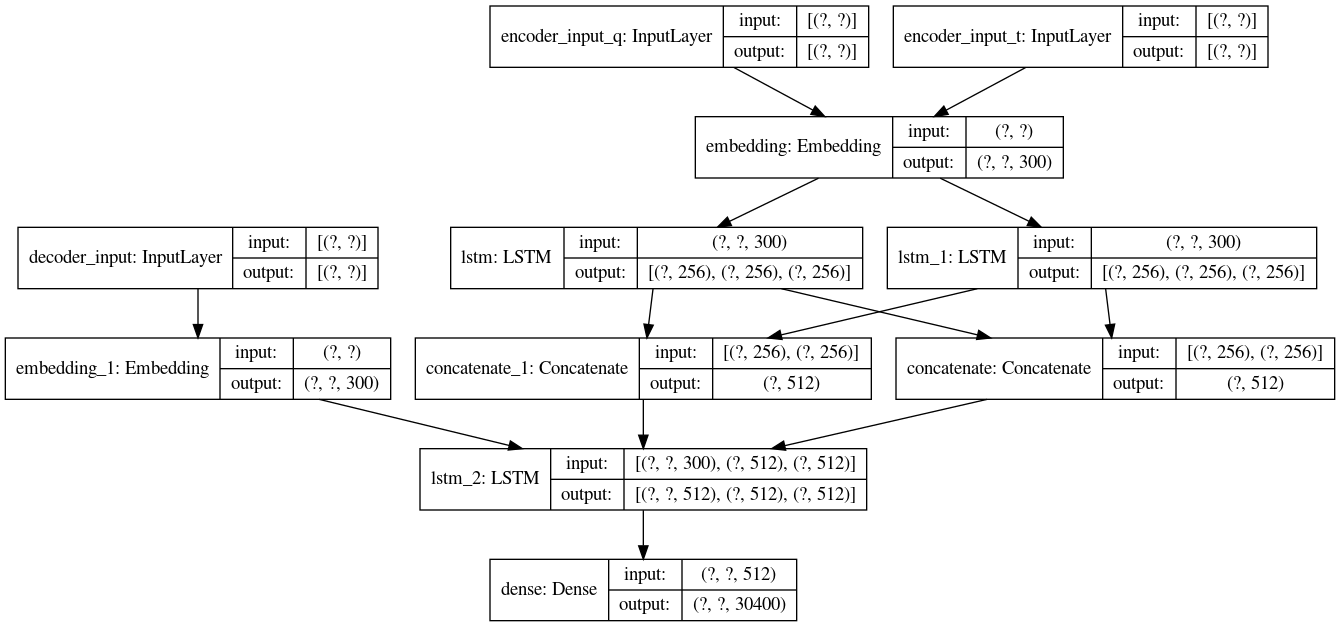

In [19]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

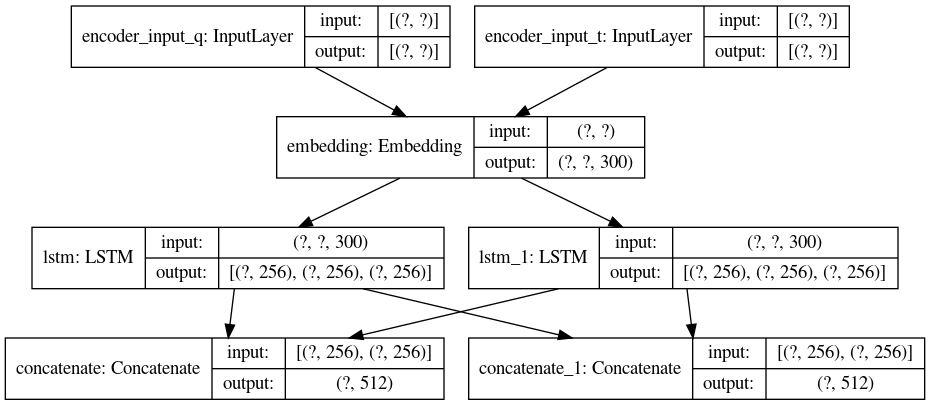

In [20]:
plot_model(
    encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

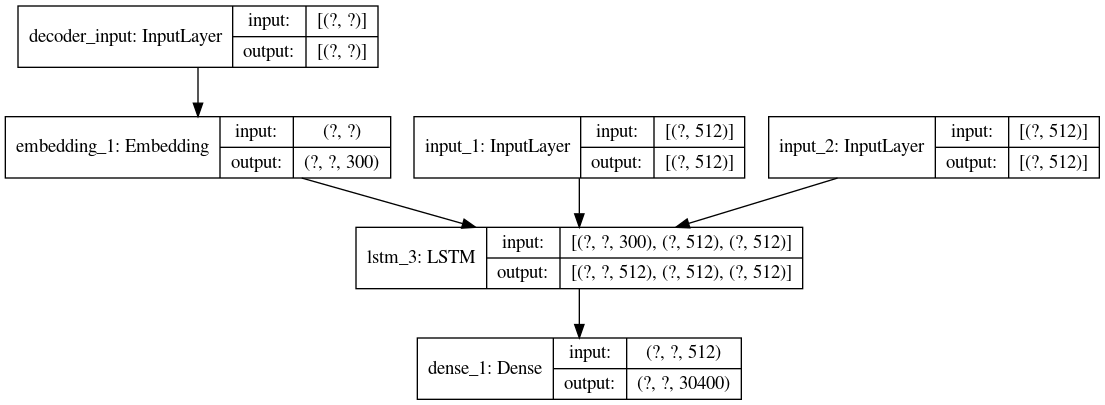

In [21]:
plot_model(
    decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [22]:
def generate_batch(train_question, train_text, train_short_answer, batch_size = 128): 
    while True:
        for j in range(0, len(train_question), batch_size):
            encoder_input_q = np.array(train_question[j:j+batch_size])
            encoder_input_t = np.array(train_text[j:j+batch_size])
            decoder_input_data = np.array(train_short_answer[j:j+batch_size])
            
            decoder_target_data = np.zeros((encoder_input_q.shape[0], 25, vocab_size_dec),dtype='float32')
            for i, target_text in enumerate(train_short_answer[j:j+batch_size]):
                for t, index in enumerate(target_text):
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        decoder_target_data[i, t - 1, index] = 1.
           
            yield([encoder_input_q, encoder_input_t, decoder_input_data], decoder_target_data)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [24]:
train_samples = len(train_questions)
val_samples = len(val_questions)
batch_size = 128
epochs = 50

In [25]:
model.fit_generator(generator = generate_batch(train_questions, train_text, train_short_answer, batch_size = batch_size), 
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(val_questions, val_text, val_short_answer, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/50
193/193 [==============================] - 240s 1s/step - loss: 1.1359 - acc: 0.1492 - val_loss: 0.9225 - val_acc: 0.0701
Epoch 2/50
193/193 [==============================] - 238s 1s/step - loss: 0.9150 - acc: 0.0916 - val_loss: 0.8748 - val_acc: 0.0867
Epoch 3/50
193/193 [==============================] - 237s 1s/step - loss: 0.8710 - acc: 0.0941 - val_loss: 0.8715 - val_acc: 0.0885
Epoch 4/50
193/193 [==============================] - 237s 1s/step - loss: 0.8441 - acc: 0.0947 - val_loss: 0.8698 - val_acc: 0.0896
Epoch 5/50
193/193 [==============================] - 237s 1s/step - loss: 0.8205 - acc: 0.0951 - val_loss: 0.8635 - val_acc: 0.0908
Epoch 6/50
193/193 [==============================] - 238s 1s/step - loss: 0.7973 - acc: 0.0953 - val_loss: 0.8642 - val_acc: 0.0913
Epoch 7/50
193/193 [==============================] - 238s 1s/step - loss: 0.7753 - acc: 0.0955 - val_loss: 0.8632 - val_acc: 0.0916
Epoch 8/50
193/193 [==============================] - 238s 1s/step - 

In [26]:
model.save_weights('model_baseline_short.h5')

In [27]:
model.load_weights('model_baseline_short.h5')

In [37]:
def decode_sequence(text, question):
    # Encode the input as state vectors.
    input_seq = [np.array(question).reshape(1, 20),np.array(text.reshape(1, 400)) ]
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tokenizer_Y.word_index['startseq']
 
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer_Y.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char 
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'endseq' or
           len(decoded_sentence.split()) > 25):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [59]:
print("annotation_id: {}".format(test.iloc[0]['annotation_id']))
print("Text: {}...".format(test.iloc[0]['text'][:200]))
print("Question: {}".format(test.iloc[0]['question']))
print()
print("Predicted Answer: {}".format( decode_sequence(test_text[0], test_questions[0]) ))

annotation_id: -1011141123527297803
Text: <P> Since 1997 , US courts have divided price fixing into two categories : vertical and horizontal maximum price fixing . Vertical price fixing includes a manufacturer 's attempt to control the price ...
Question: association of producers that control supply and prices

Predicted Answer: Since 1997 , US courts have divided price fixing


In [68]:
print("annotation_id: {}".format(test.iloc[1]['annotation_id']))
print("Text: {}...".format(test.iloc[1]['text'][:200]))
print("Question: {}".format(test.iloc[1]['question']))
print()
print("Predicted Answer: {}".format( decode_sequence(test_text[1], test_questions[1]) ))

annotation_id: -1028916936938579349
Text: <P> The title You 've Come a Long Way , Baby was derived from a marketing slogan for Virginia Slims cigarettes . Conceived by Red Design , the album 's primary cover art features an obese young man dr...
Question: norman cook you've come a long way

Predicted Answer: slogan for Virginia Slims cigarettes . Conceived by Red Design , the album 's primary cover art features an obese young


In [73]:
print("annotation_id: {}".format(test.iloc[3]['annotation_id']))
print("Text: {}...".format(test.iloc[3]['text'][:200]))
print("Question: {}".format(test.iloc[3]['question']))
print()
print("Predicted Answer: {}".format( decode_sequence(test_text[3], test_questions[3]) ))

annotation_id: -1074129516932871805
Text: <Tr> <Th> Location </Th> <Td> Tilak Marg , New Delhi , Delhi </Td> </Tr>...
Question: who appoint the judge of supreme court and high court

Predicted Answer: Tilak Marg


In [77]:
print("annotation_id: {}".format(test.iloc[4]['annotation_id']))
print("Text: {}...".format(test.iloc[4]['text'][:200]))
print("Question: {}".format(test.iloc[4]['question']))
print()
print("Predicted Answer: {}".format( decode_sequence(test_text[4], test_questions[4]) ))

annotation_id: -1114334749483663139
Text: <P> Brooke has an end of the summer party on the beach . Nathan is home from basketball camp . Lucas deals with Brooke 's rules for non-exclusive dating . Brooke ends up having a ball with many guys w...
Question: who released the time capsule in one tree hill

Predicted Answer: NONE


In [86]:
print("annotation_id: {}".format(test.iloc[5]['annotation_id']))
print("Text: {}...".format(test.iloc[5]['text'][:200]))
print("Question: {}".format(test.iloc[5]['question']))
print()
print("Predicted Answer: {}".format( decode_sequence(test_text[5], test_questions[5]) ))

annotation_id: -1152268629614456016
Text: <P> Server Core does not include the . NET Framework , Internet Explorer , Windows PowerShell or many other features not related to core server features . A Server Core machine can be configured for s...
Question: what feature introduced with windows server 2008 provides only a limited gui

Predicted Answer: NET Framework , Internet Explorer , Windows PowerShell or many other features
